# Loading Dataset and some files

In [ ]:
%cd drive/MyDrive/CS689 # when using google colab

In [ ]:
%cd CS689_RealtimeSaliency

**data and place in the folder of CS689_RealtimeSaliency**   
[google drive data link](https://drive.google.com/drive/folders/13B6qYalxXpkiwoqEAbDgOalfuOQi1zi4?usp=sharing)

# Importing Libraries

In [ ]:
!sudo apt-get install python-wxtools
import numpy as np

# Step 1: Deciding the training dataset and the black-box model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet():
    return ResNet(BasicBlock, [2,2,2,2])

# Step 2: Training the Black box model on the training set


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from scipy import misc
from resnet import resnet

def save_checkpoint(state, filename='black_box_func.pth'):
    torch.save(state, filename)
#it seems wrong tar ,so convert to pth
#def load_checkpoint(net,optimizer,filename='black_box_func.pth'):
 #   checkpoint = torch.load(filename)
  #  net.load_state_dict(checkpoint['state_dict'])
   # optimizer.load_state_dict(checkpoint['optimizer'])
    #return net,optimizer
#it has not been used for the code

def cifar10():
    
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                            shuffle=False, num_workers=2)

    return trainloader,testloader,classes
 
trainloader,testloader,classes = cifar10()

black_box_func = resnet()
black_box_func = black_box_func.cuda()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(black_box_func.parameters())

for epoch in range(6):  # loop over the dataset multiple times

    
    running_loss = 0.0
    running_corrects = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out = black_box_func(inputs)

        _, preds = torch.max(out.data, 1)
        loss = criterion(out,labels)   
        running_corrects += torch.sum(preds == labels.data)
        running_corrects=running_corrects.float()#avoid the acc=0
        running_loss += loss.data
        if(i%100 == 0):
          print('Epoch = %f , Accuracy = %f, Loss = %f '%(epoch+1 , running_corrects/(4*(i+1)), running_loss/(4*(i+1))) )
       
        loss.backward()
        optimizer.step()
    
    save_checkpoint(black_box_func, filename='black_box_func.pth')

170499072it [00:03, 50992485.50it/s]                   
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch = 1.000000 , Accuracy = 0.250000, Loss = 0.526331 
Epoch = 1.000000 , Accuracy = 0.143564, Loss = 0.657104 
Epoch = 1.000000 , Accuracy = 0.128109, Loss = 0.632341 
Epoch = 1.000000 , Accuracy = 0.131229, Loss = 0.622110 
Epoch = 1.000000 , Accuracy = 0.137157, Loss = 0.610246 
Epoch = 1.000000 , Accuracy = 0.147206, Loss = 0.598835 
Epoch = 1.000000 , Accuracy = 0.155990, Loss = 0.590952 
Epoch = 1.000000 , Accuracy = 0.166191, Loss = 0.584110 
Epoch = 1.000000 , Accuracy = 0.168539, Loss = 0.578716 
Epoch = 1.000000 , Accuracy = 0.173696, Loss = 0.572926 
Epoch = 1.000000 , Accuracy = 0.181069, Loss = 0.567973 
Epoch = 1.000000 , Accuracy = 0.185740, Loss = 0.563510 
Epoch = 1.000000 , Accuracy = 0.190258, Loss = 0.559454 
Epoch = 1.000000 , Accuracy = 0.192160, Loss = 0.555914 
Epoch = 1.000000 , Accuracy = 0.196645, Loss = 0.551304 


# Step 3: Developing the saliency model for the black-box model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class PixelShuffleBlock(nn.Module):
    def forward(self, x):
        return F.pixel_shuffle(x, 2)
      

def CNNBlock(in_channels, out_channels,
                 kernel_size=3, layers=1, stride=1,
                 follow_with_bn=True, activation_fn=lambda: nn.ReLU(True), affine=True):

        assert layers > 0 and kernel_size%2 and stride>0
        current_channels = in_channels
        _modules = []
        for layer in range(layers):
            _modules.append(nn.Conv2d(current_channels, out_channels, kernel_size, stride=stride if layer==0 else 1, padding=int(kernel_size/2), bias=not follow_with_bn))
            current_channels = out_channels
            if follow_with_bn:
                _modules.append(nn.BatchNorm2d(current_channels, affine=affine))
            if activation_fn is not None:
                _modules.append(activation_fn())
        return nn.Sequential(*_modules)

def SubpixelUpsampler(in_channels, out_channels, kernel_size=3, activation_fn=lambda: torch.nn.ReLU(inplace=False), follow_with_bn=True):
    _modules = [
        CNNBlock(in_channels, out_channels * 4, kernel_size=kernel_size, follow_with_bn=follow_with_bn),
        PixelShuffleBlock(),
        activation_fn(),
    ]
    return nn.Sequential(*_modules)

class UpSampleBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels,passthrough_channels, stride=1):
        super(UpSampleBlock, self).__init__()
        self.upsampler = SubpixelUpsampler(in_channels=in_channels,out_channels=out_channels)
        self.follow_up = Block(out_channels+passthrough_channels,out_channels)

    def forward(self, x, passthrough):
        out = self.upsampler(x)
        out = torch.cat((out,passthrough), 1)
        return self.follow_up(out)



class Block(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class SaliencyModel(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SaliencyModel, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block=block, planes=64, num_blocks=num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block=block, planes=128, num_blocks=num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block=block, planes=256, num_blocks=num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block=block, planes=512, num_blocks=num_blocks[3], stride=2)
        
        self.uplayer4 = UpSampleBlock(in_channels=512,out_channels=256,passthrough_channels=256)
        self.uplayer3 = UpSampleBlock(in_channels=256,out_channels=128,passthrough_channels=128)
        self.uplayer2 = UpSampleBlock(in_channels=128,out_channels=64,passthrough_channels=64)
        
        self.embedding = nn.Embedding(num_classes,512)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.saliency_chans = nn.Conv2d(64,2,kernel_size=1,bias=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    

    
    def forward(self, x,labels):
        out = F.relu(self.bn1(self.conv1(x)))
        
        scale1 = self.layer1(out)
        scale2 = self.layer2(scale1)
        scale3 = self.layer3(scale2)
        scale4 = self.layer4(scale3)

      
        em = torch.squeeze(self.embedding(labels.view(-1, 1)), 1)
        act = torch.sum(scale4*em.view(-1, 512, 1, 1), 1, keepdim=True)
        th = torch.sigmoid(act)
        scale4 = scale4*th
        
        
        upsample3 = self.uplayer4(scale4,scale3)
        upsample2 = self.uplayer3(upsample3,scale2)
        upsample1 = self.uplayer2(upsample2,scale1)
        
        saliency_chans = self.saliency_chans(upsample1)
        
        
        out = F.avg_pool2d(scale4, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        a = torch.abs(saliency_chans[:,0,:,:])
        b = torch.abs(saliency_chans[:,1,:,:])
        
        return torch.unsqueeze(a/(a+b), dim=1), out


def saliency_model():
    return SaliencyModel(Block, [2,2,2,2])

# Step 4: Training the Saliency model on defined loss function keeping Black box model weights as frozen


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from scipy import misc
from model import saliency_model
from resnet import resnet
from loss import Loss

def save_checkpoint(state, filename='saliency_model.pth'):
    torch.save(state, filename)

#def load_checkpoint(net,optimizer,filename='small.pth.tar'):
 #   checkpoint = torch.load(filename)
  #  net.load_state_dict(checkpoint['state_dict'])
   # optimizer.load_state_dict(checkpoint['optimizer'])
    #return net,optimizer
#resnet() is better to load its whole model rather than its state_dict
def load_checkpoint(net,filename='black_box_func.pth'):
    net = torch.load(filename)
    
 #when calculate the destroy loss and preserve loss ,the resnet should be pretrained , so we would load the black_box_func.pth   
def cifar10():
    
    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                            shuffle=False, num_workers=2)

    return trainloader,testloader,classes
from tqdm import tqdm

def train():
    num_epochs = 6
    trainloader,testloader,classes = cifar10()

    net = saliency_model()
    net = net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())

    black_box_func = resnet()
    black_box_func = black_box_func.cuda()
    print(type(black_box_func))
    # black_box_func=load_checkpoint(black_box_func,filename='black_box_func.pth')
    black_box_func = torch.load('black_box_func.pth')
    print(type(black_box_func))
    #load the pretrained classfication model 
    loss_func = Loss(num_classes=10)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_corrects = 0.0
        
        for i, data in tqdm(enumerate(trainloader, 0)):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            mask,out = net(inputs,labels)
        
            loss = loss_func.get(mask,inputs,labels,black_box_func)
            # print("loss",loss.data.item())
            running_loss += loss.data.item()

            if(i%50 == 0):
                print('Epoch = %f , Loss = %f '%(epoch+1 , running_loss/(4*(i+1))) )
        
            loss.backward()
            optimizer.step()
        
        save_checkpoint(net,'saliency_model.pth')

Files already downloaded and verified
Files already downloaded and verified
<class 'resnet.ResNet'>
<class 'resnet.ResNet'>
0it [00:00, ?it/s]Epoch = 1.000000 , Loss = 1.929067 
50it [00:07,  6.61it/s]Epoch = 1.000000 , Loss = 1.948412 
100it [00:15,  6.58it/s]Epoch = 1.000000 , Loss = 1.941483 
150it [00:22,  6.61it/s]Epoch = 1.000000 , Loss = 1.939943 
200it [00:30,  6.57it/s]Epoch = 1.000000 , Loss = 1.938044 
250it [00:38,  6.56it/s]Epoch = 1.000000 , Loss = 1.944213 
300it [00:45,  6.61it/s]Epoch = 1.000000 , Loss = 1.950141 
350it [00:53,  6.59it/s]Epoch = 1.000000 , Loss = 1.946428 
400it [01:00,  6.60it/s]Epoch = 1.000000 , Loss = 1.958084 
450it [01:08,  6.59it/s]Epoch = 1.000000 , Loss = 1.957184 
500it [01:16,  6.60it/s]Epoch = 1.000000 , Loss = 1.956453 
550it [01:23,  6.63it/s]Epoch = 1.000000 , Loss = 1.947307 
600it [01:31,  6.62it/s]Epoch = 1.000000 , Loss = 1.951161 
650it [01:38,  6.62it/s]Epoch = 1.000000 , Loss = 1.947874 
700it [01:46,  6.63it/s]Epoch = 1.000000 , 

# Step 5: Visualize the results of the saliency model on the validation dataset

Files already downloaded and verified
Files already downloaded and verified


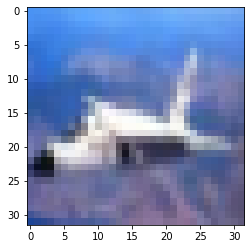

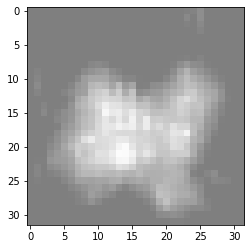

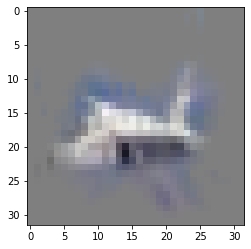

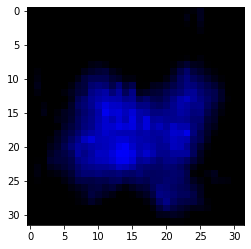

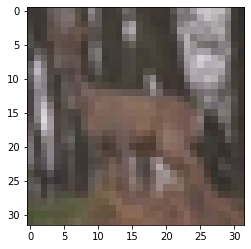

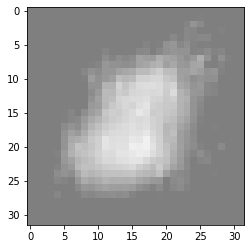

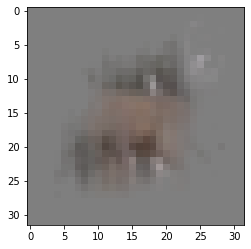

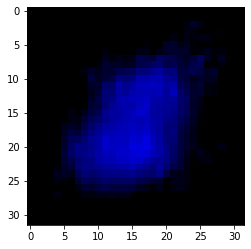

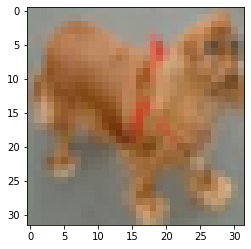

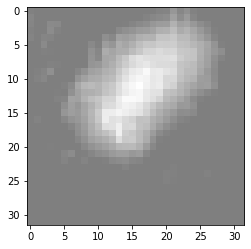

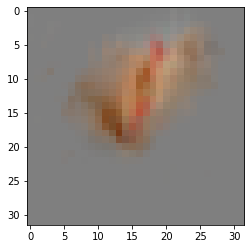

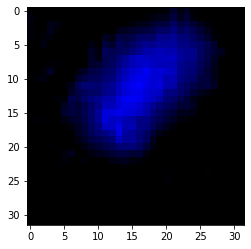

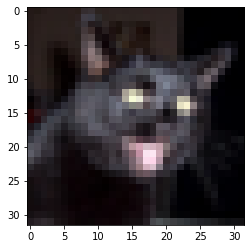

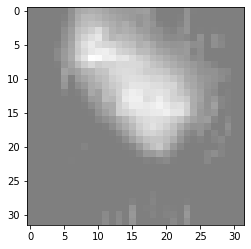

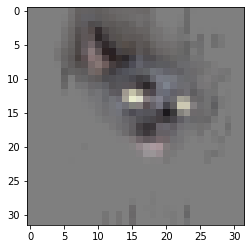

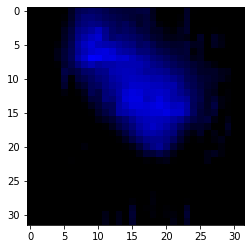

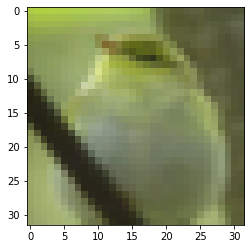

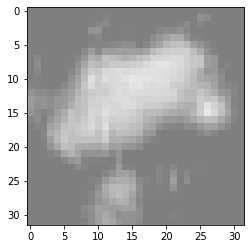

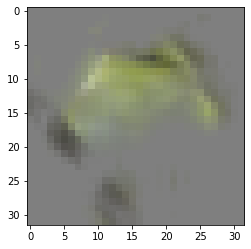

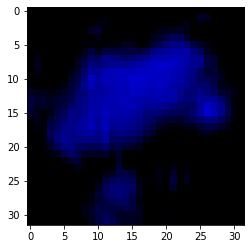

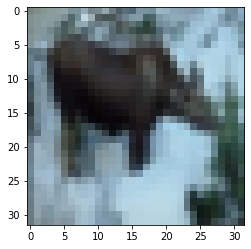

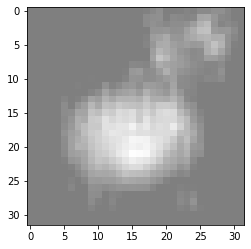

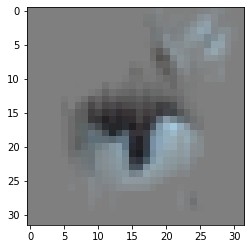

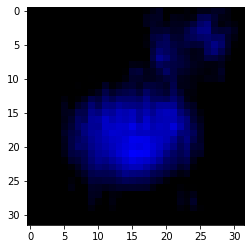

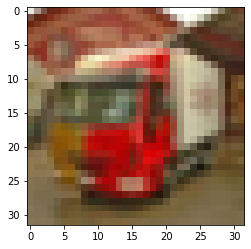

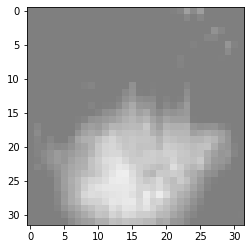

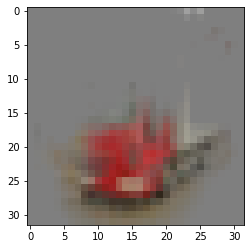

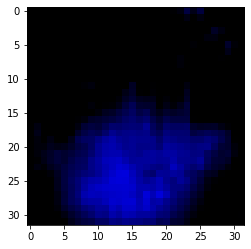

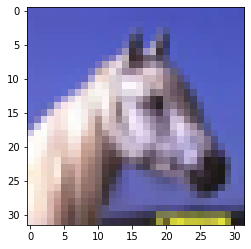

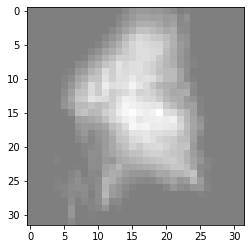

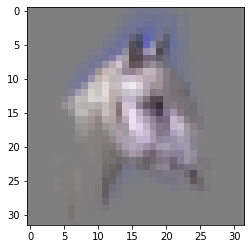

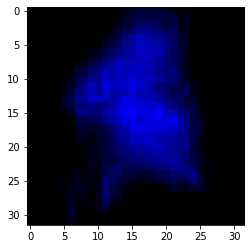

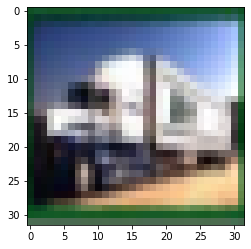

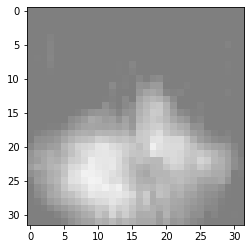

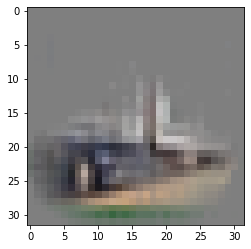

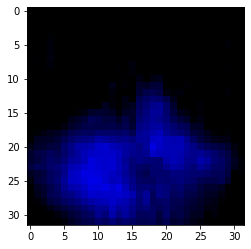

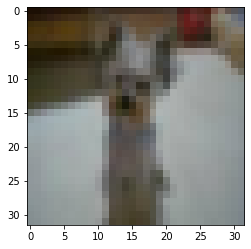

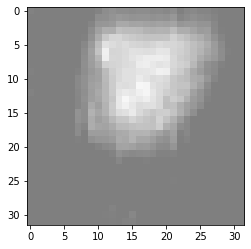

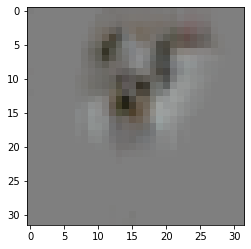

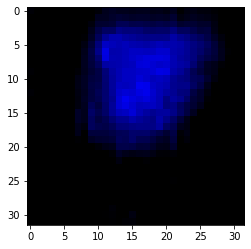

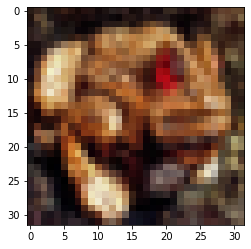

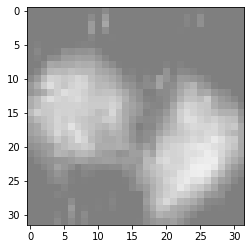

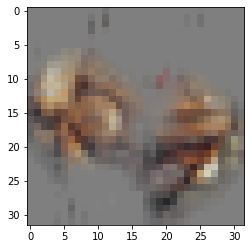

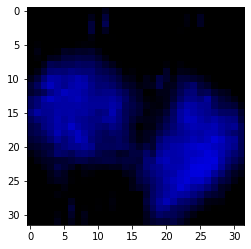

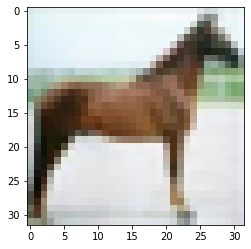

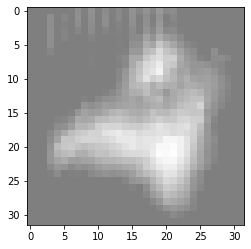

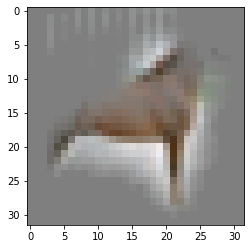

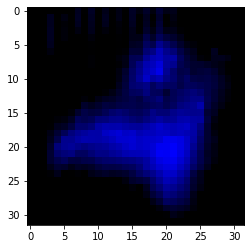

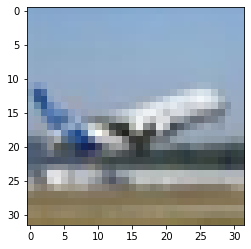

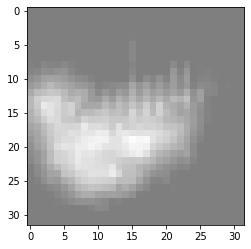

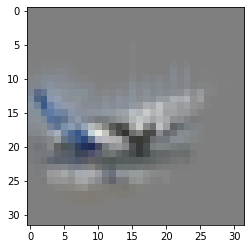

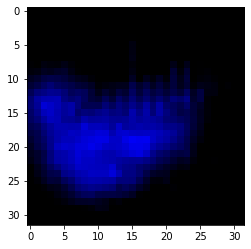

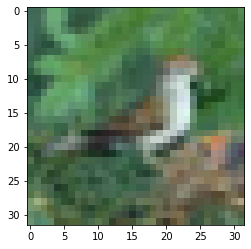

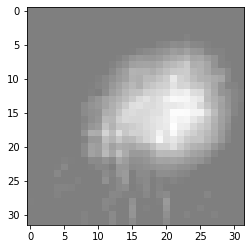

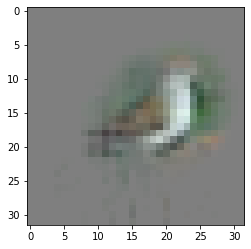

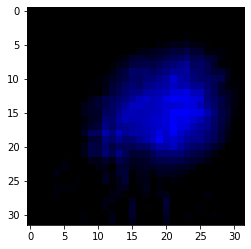

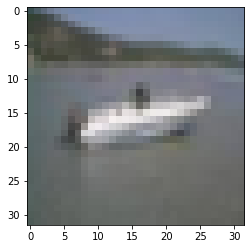

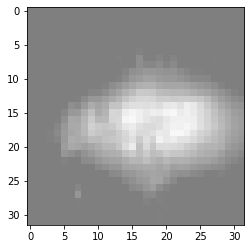

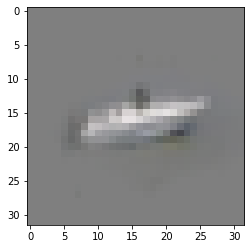

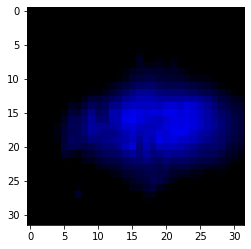

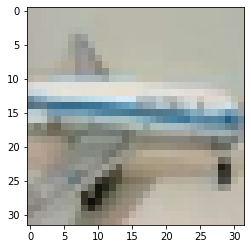

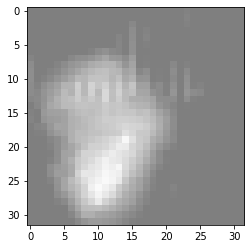

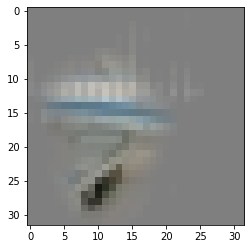

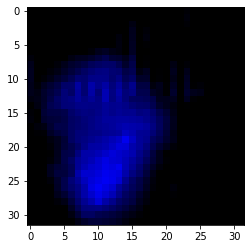

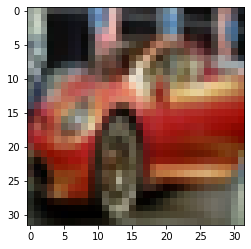

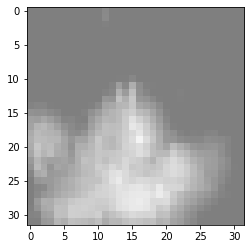

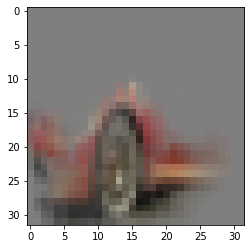

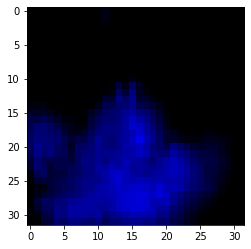

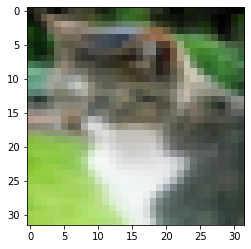

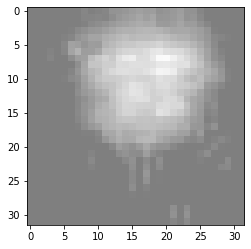

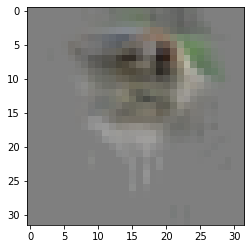

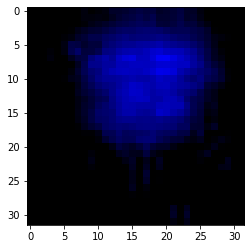

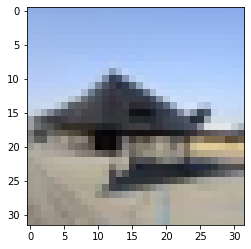

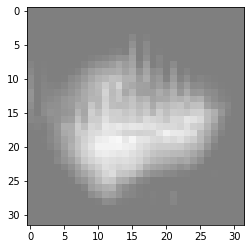

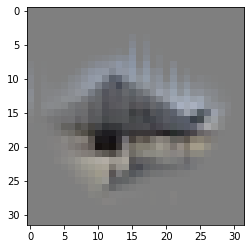

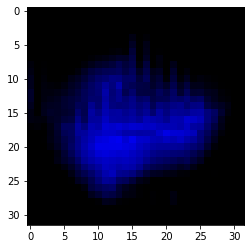

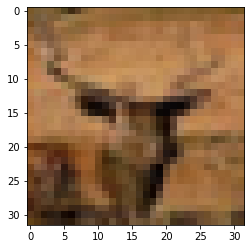

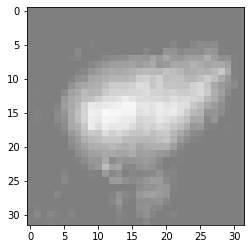

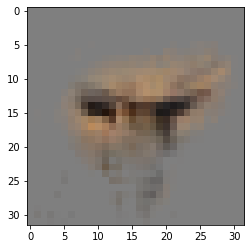

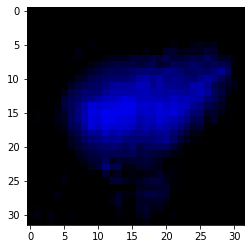

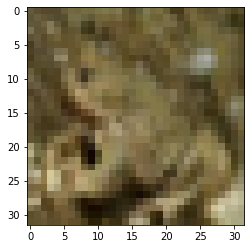

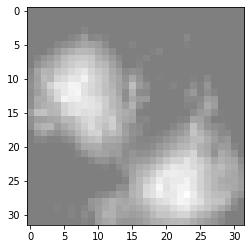

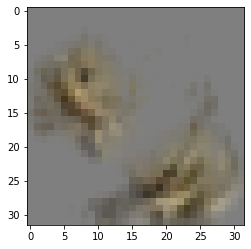

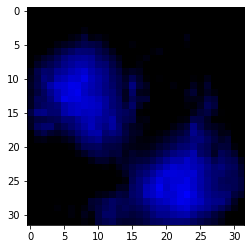

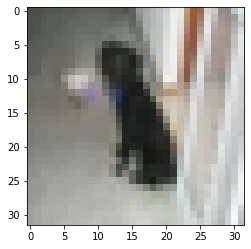

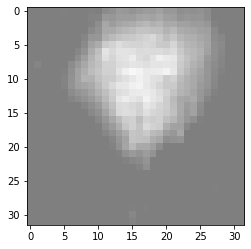

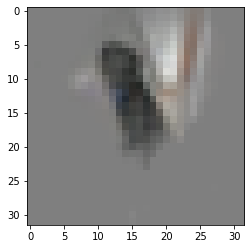

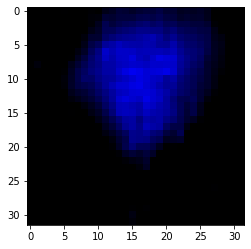

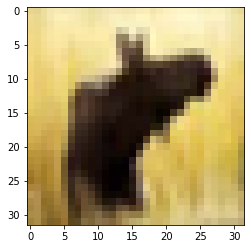

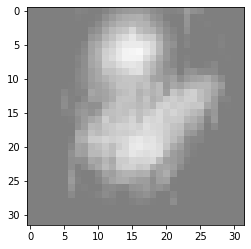

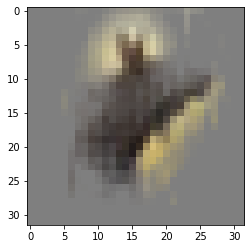

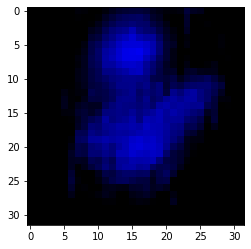

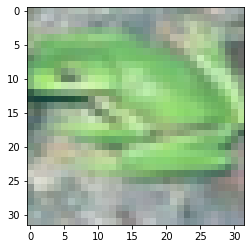

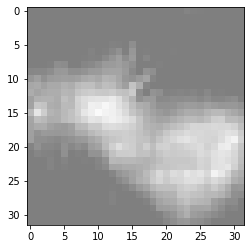

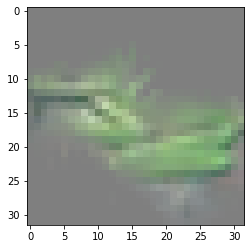

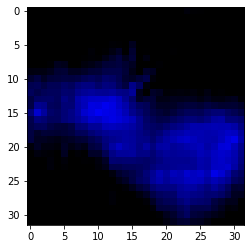

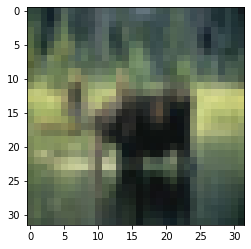

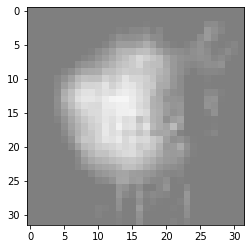

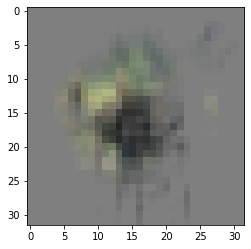

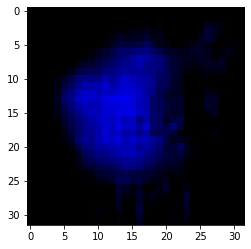

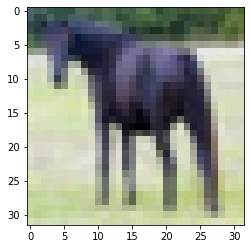

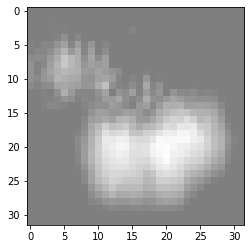

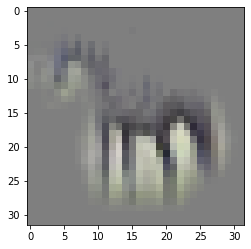

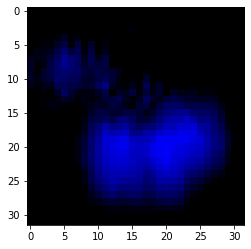

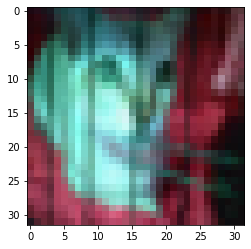

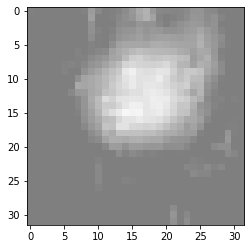

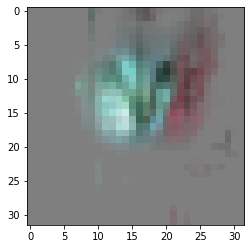

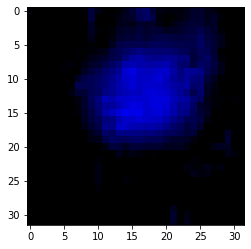

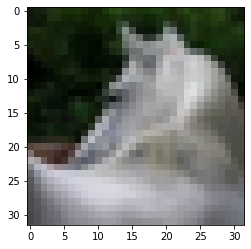

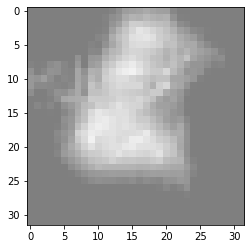

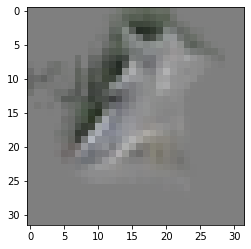

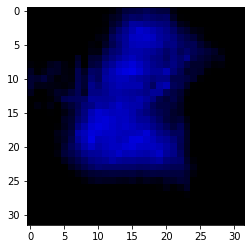

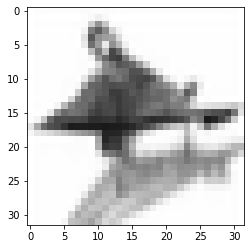

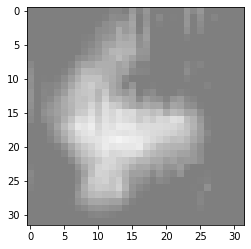

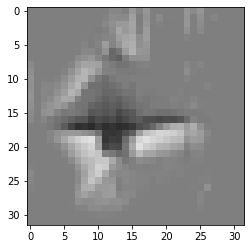

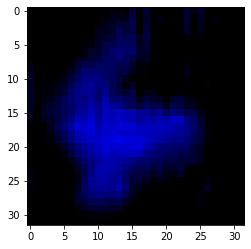

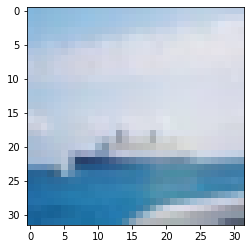

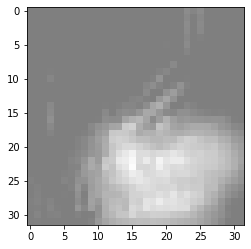

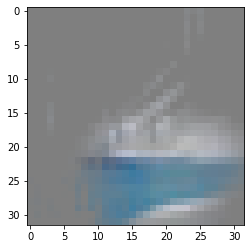

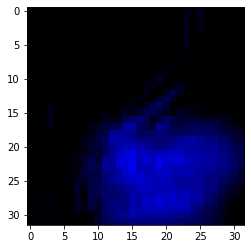

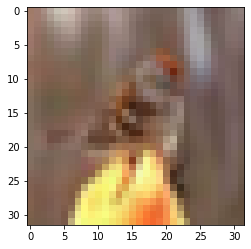

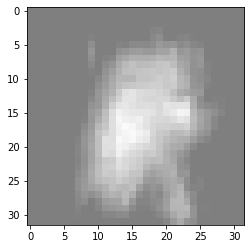

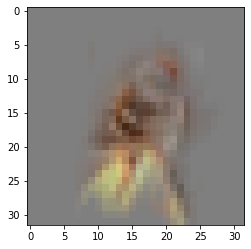

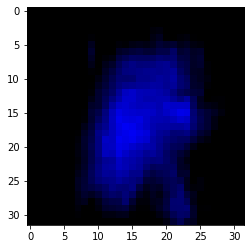

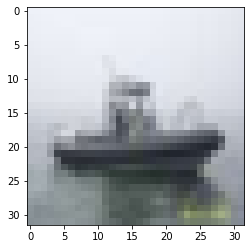

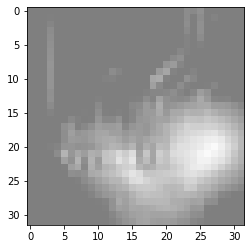

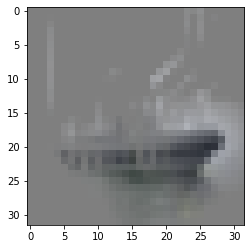

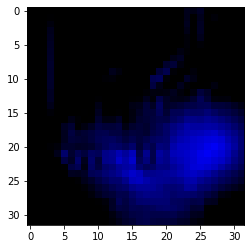

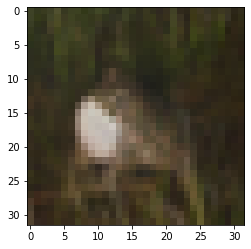

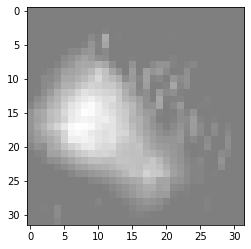

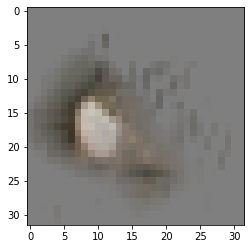

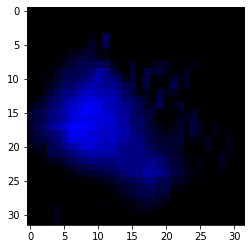

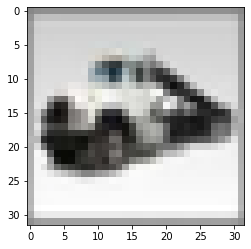

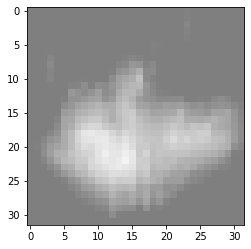

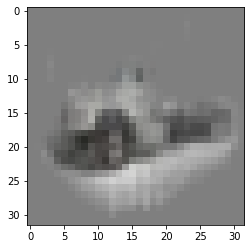

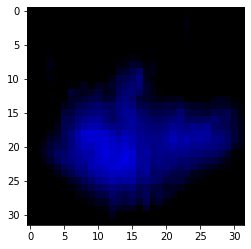

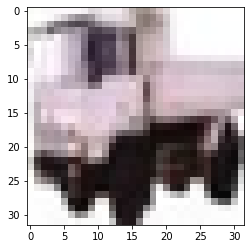

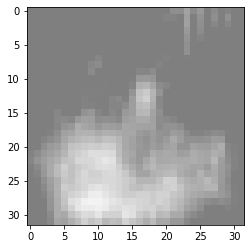

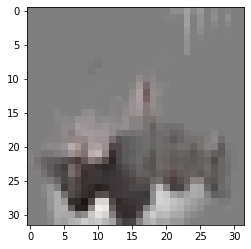

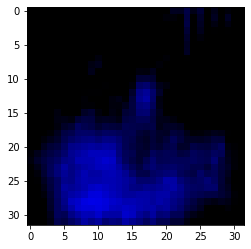

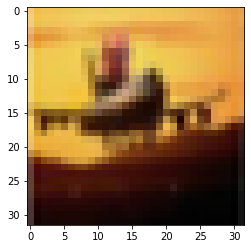

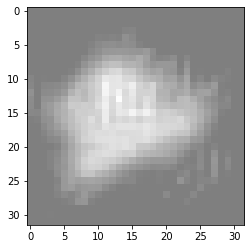

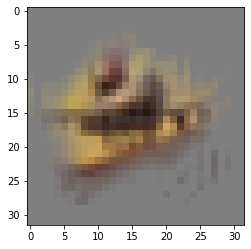

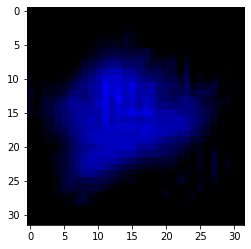

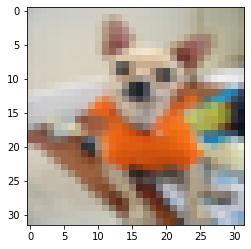

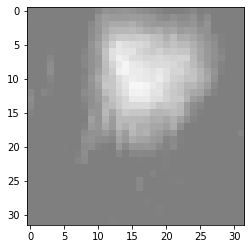

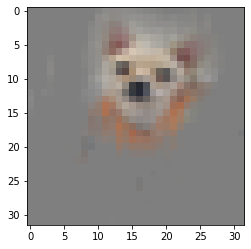

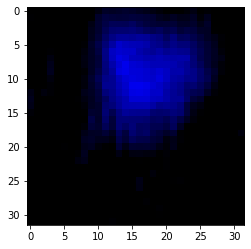

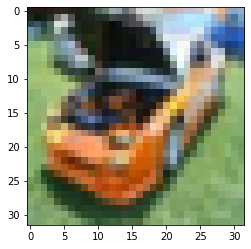

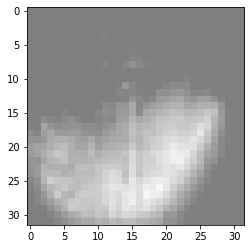

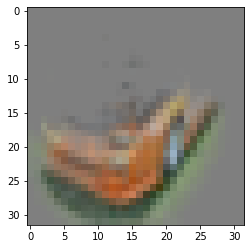

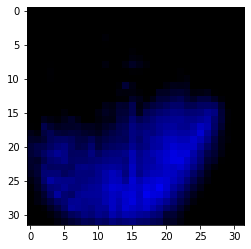

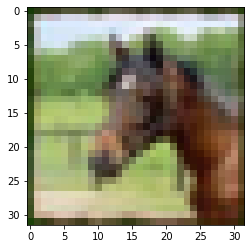

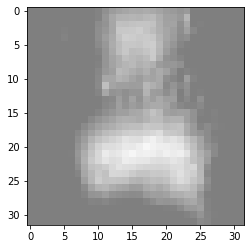

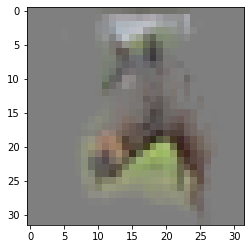

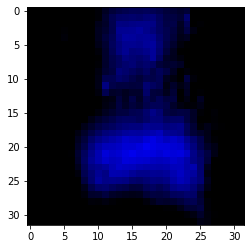

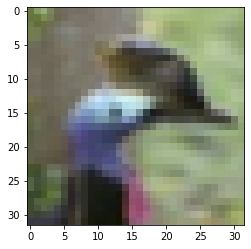

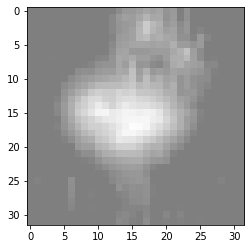

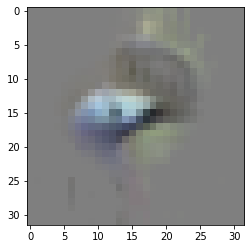

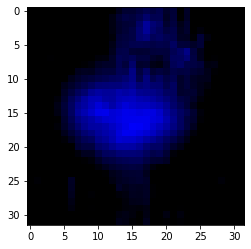

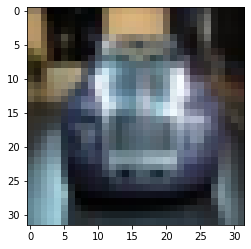

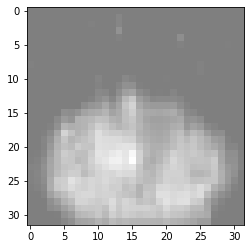

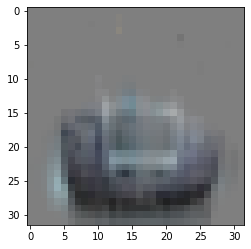

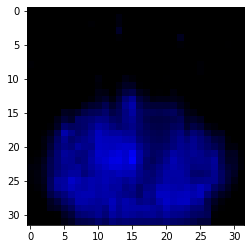

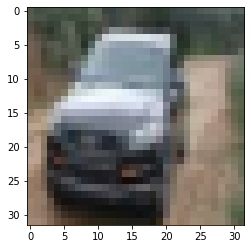

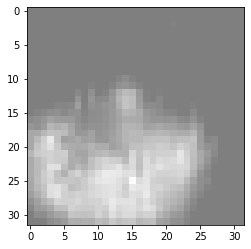

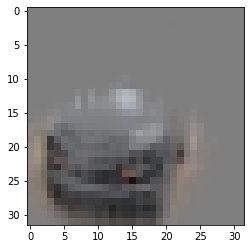

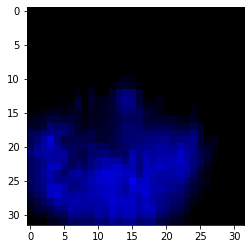

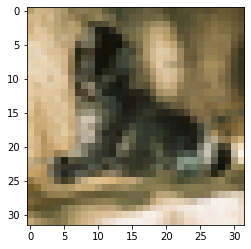

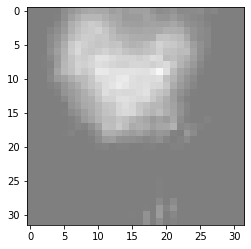

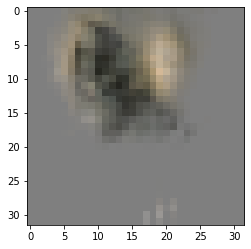

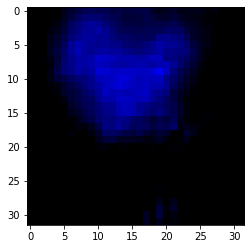

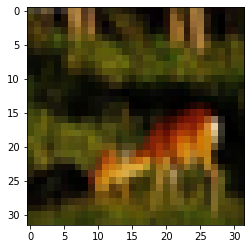

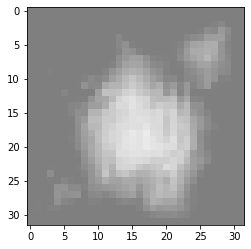

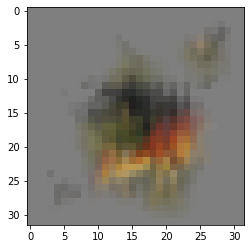

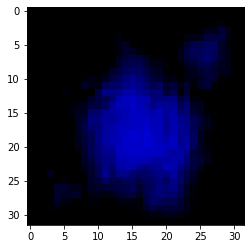

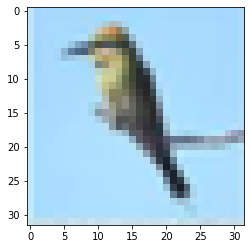

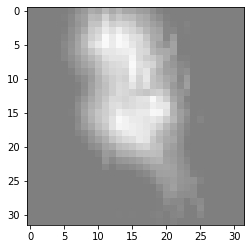

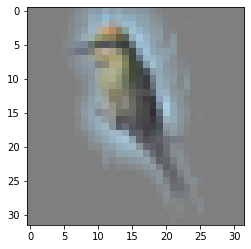

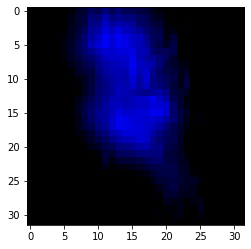

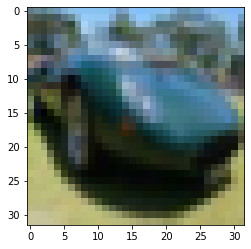

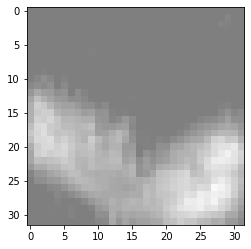

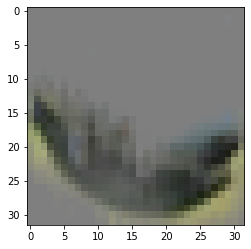

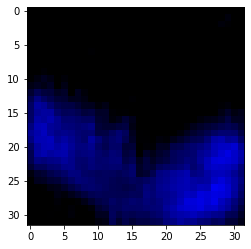

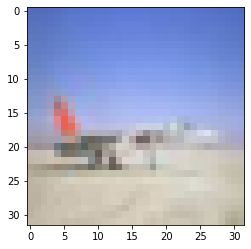

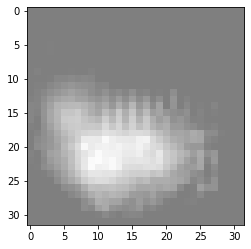

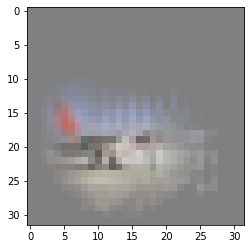

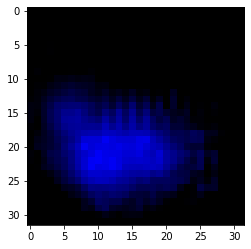

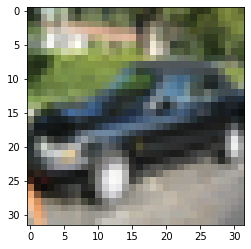

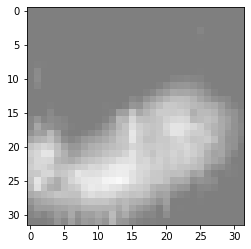

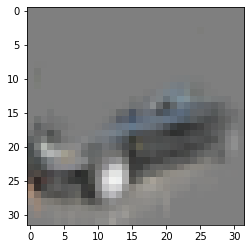

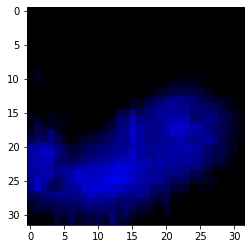

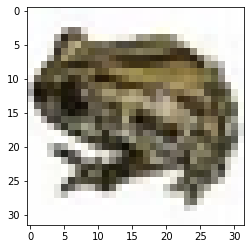

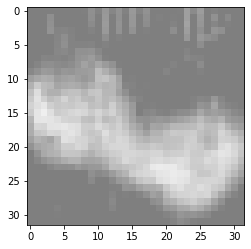

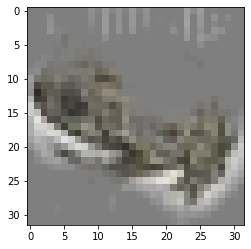

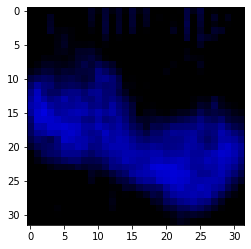

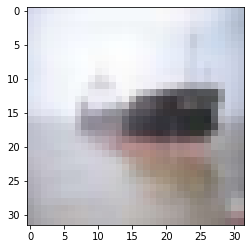

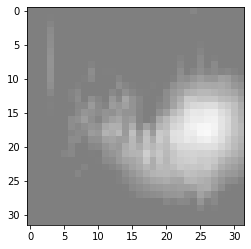

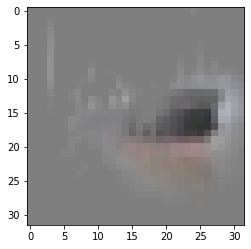

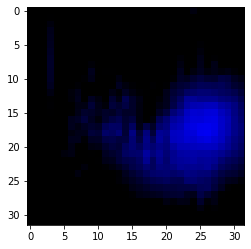

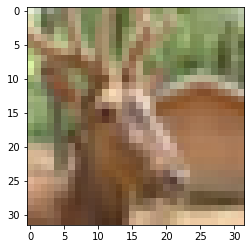

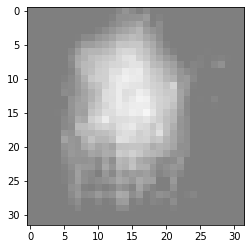

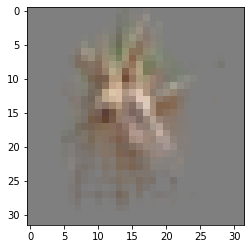

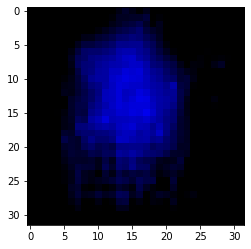

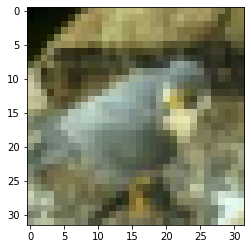

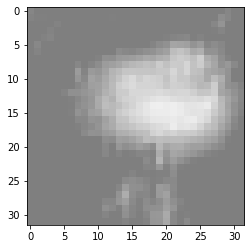

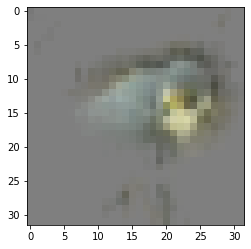

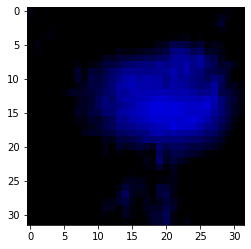

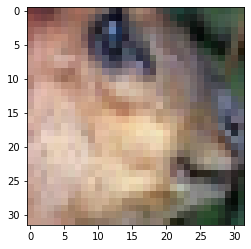

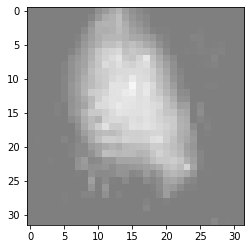

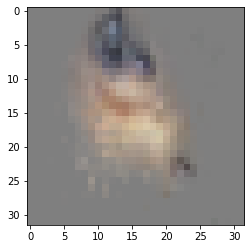

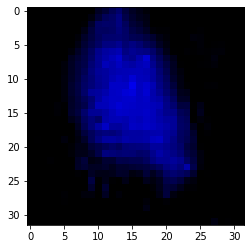

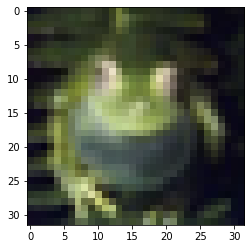

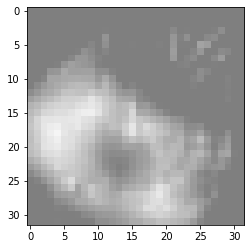

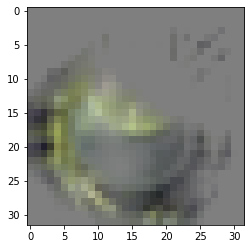

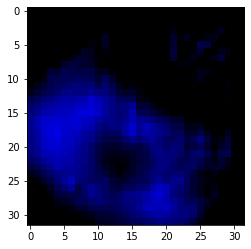

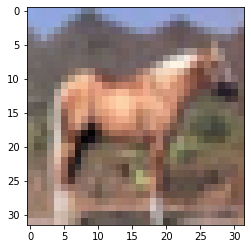

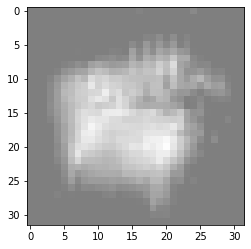

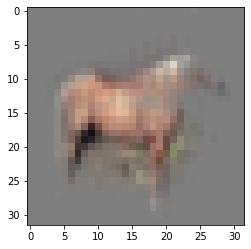

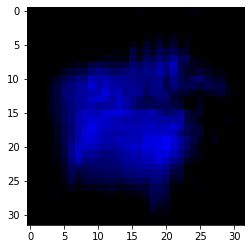

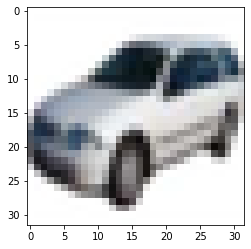

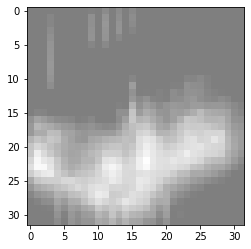

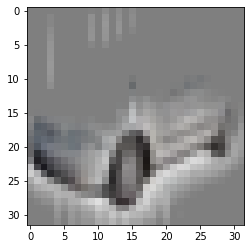

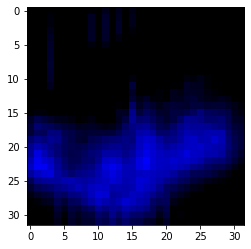

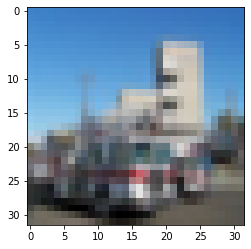

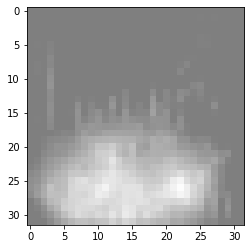

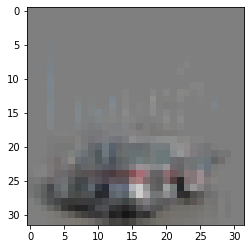

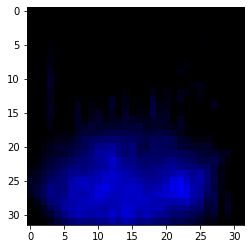

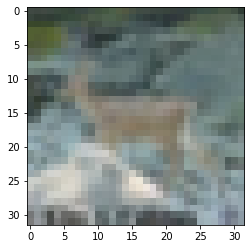

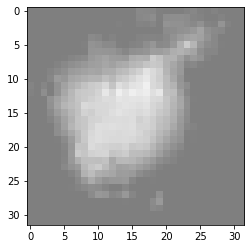

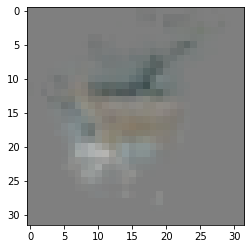

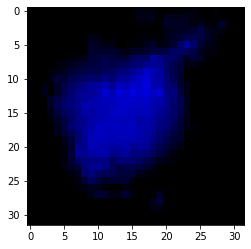

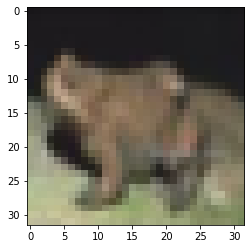

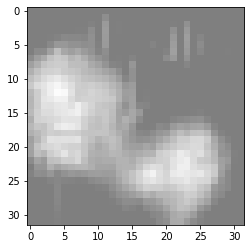

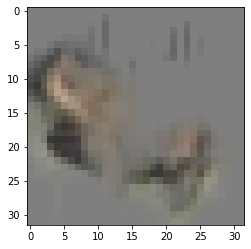

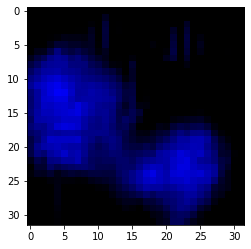

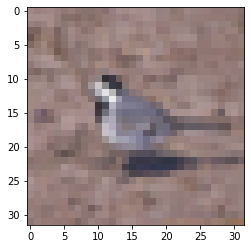

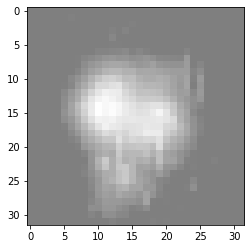

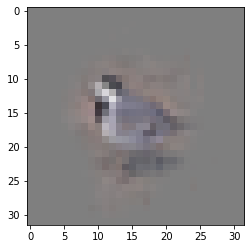

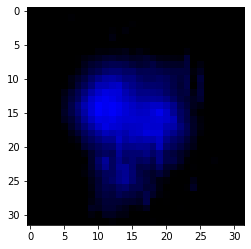

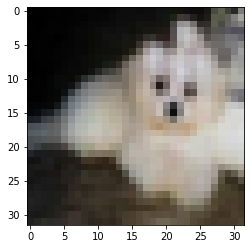

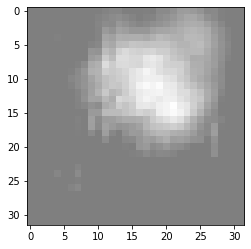

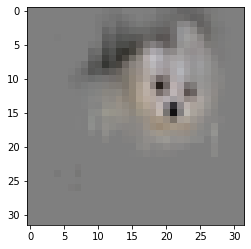

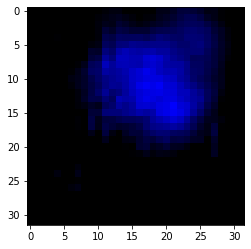

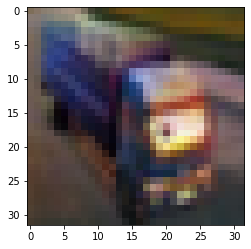

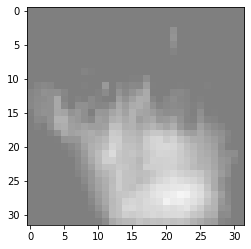

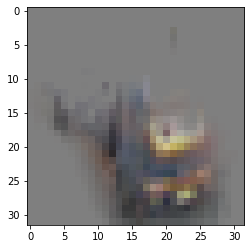

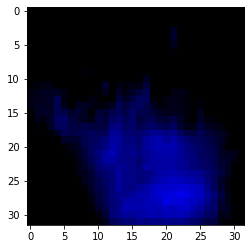

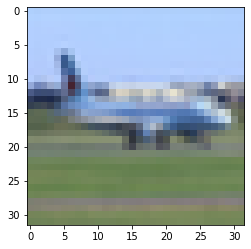

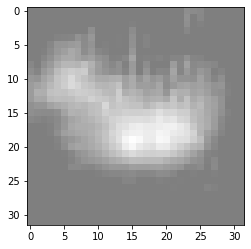

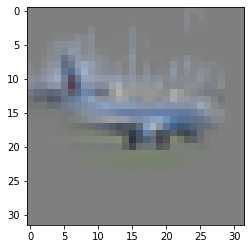

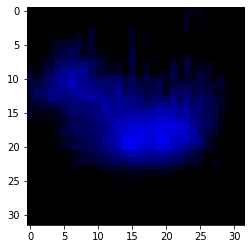

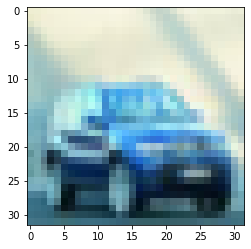

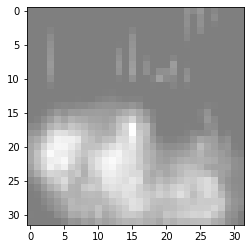

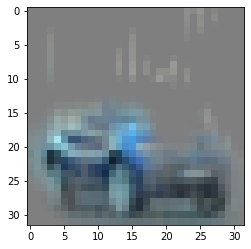

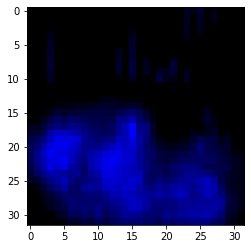

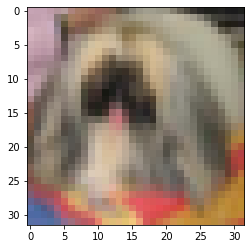

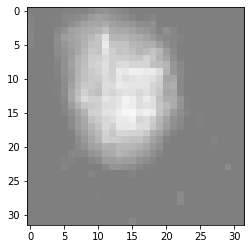

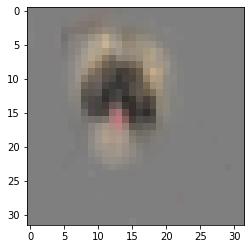

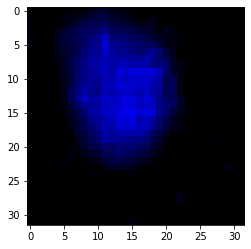

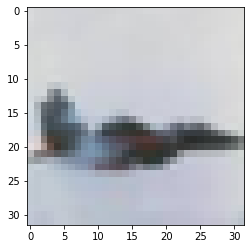

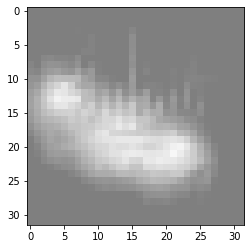

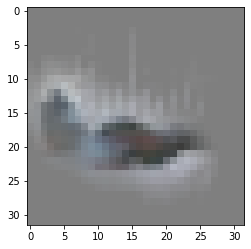

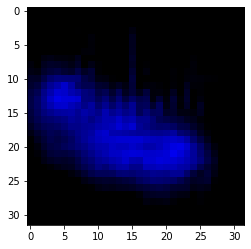

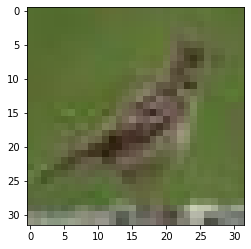

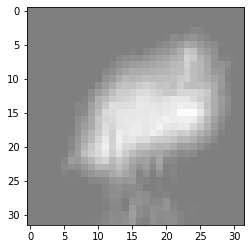

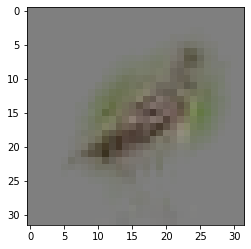

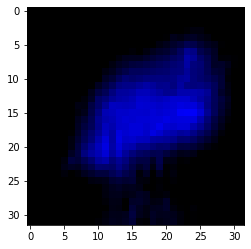

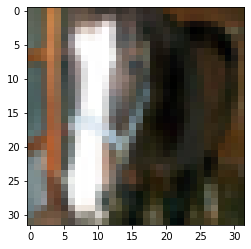

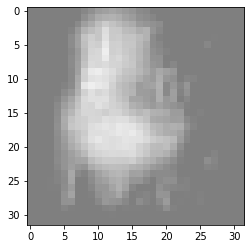

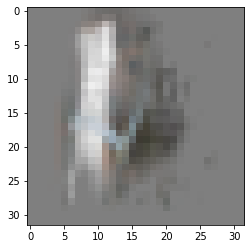

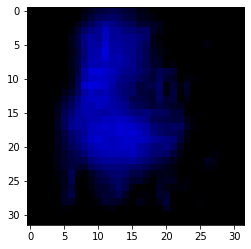

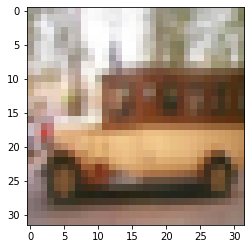

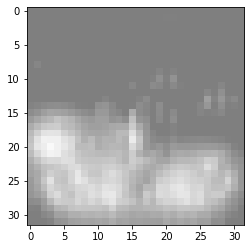

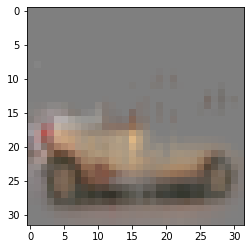

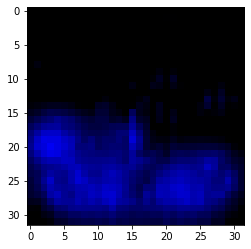

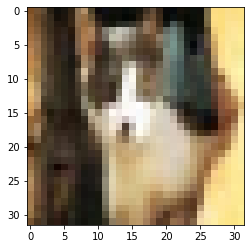

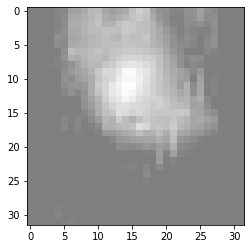

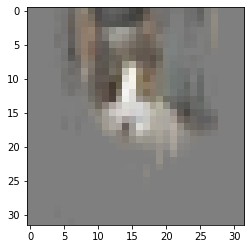

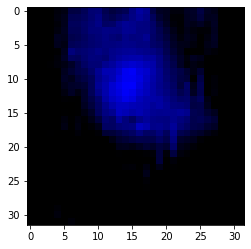

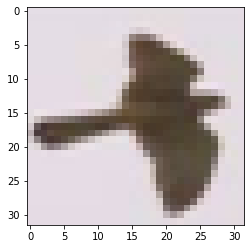

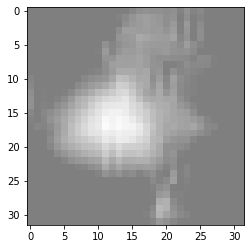

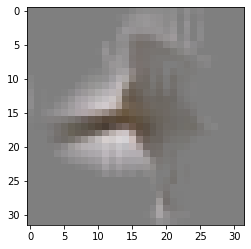

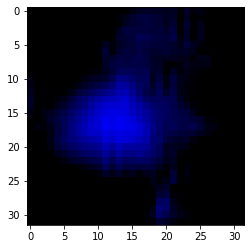

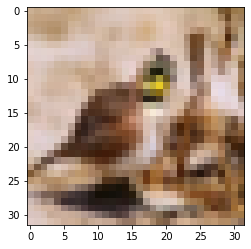

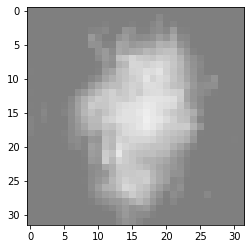

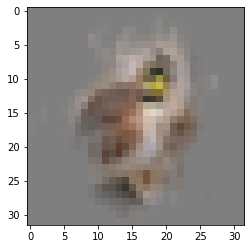

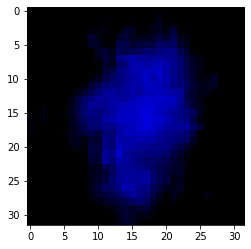

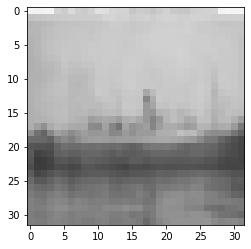

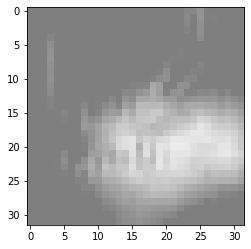

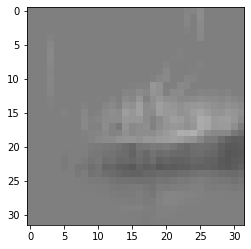

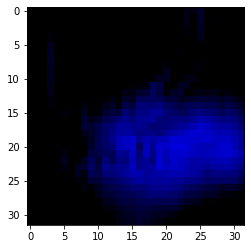

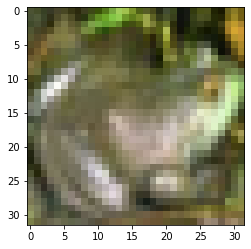

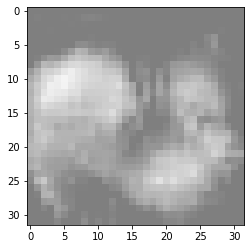

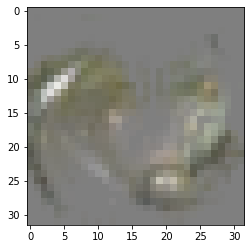

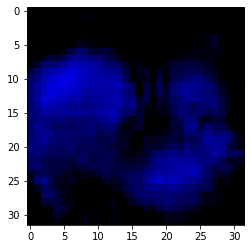

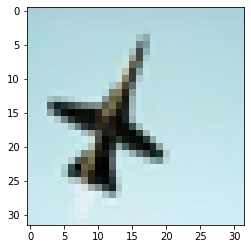

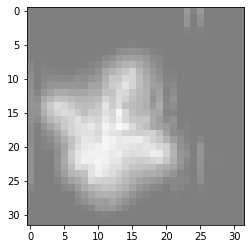

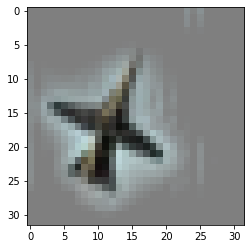

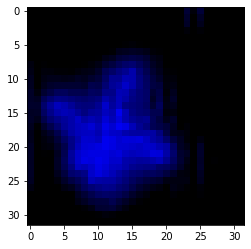

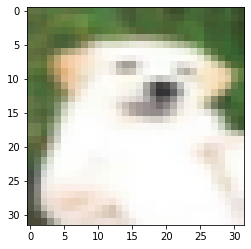

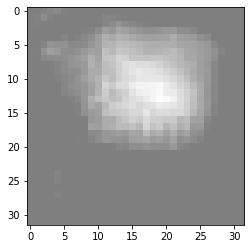

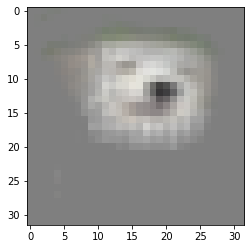

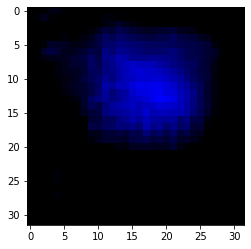

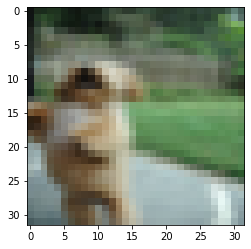

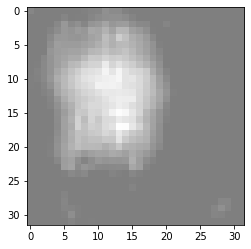

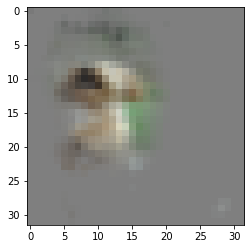

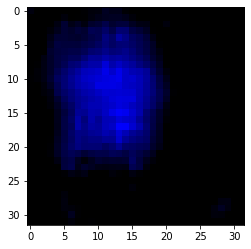

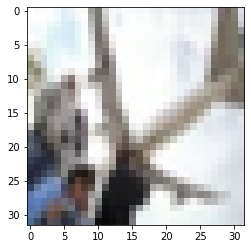

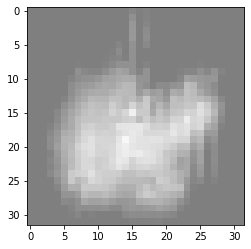

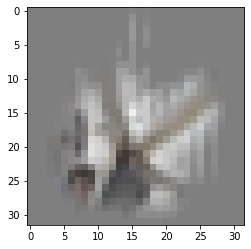

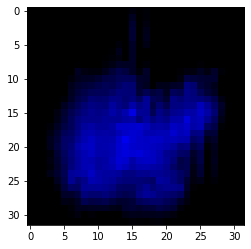

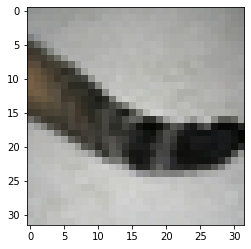

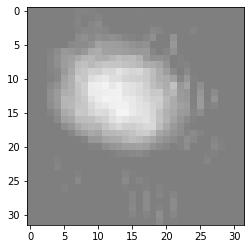

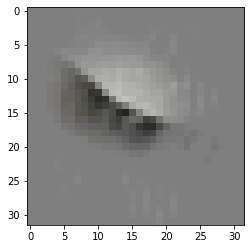

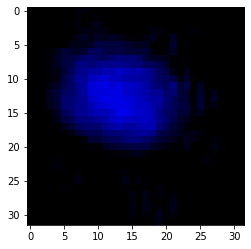

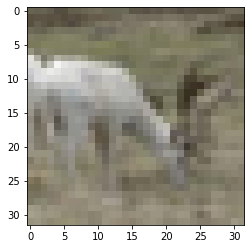

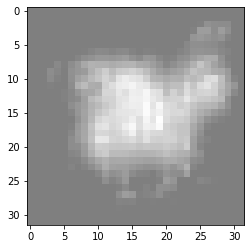

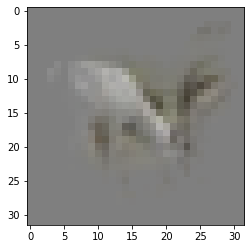

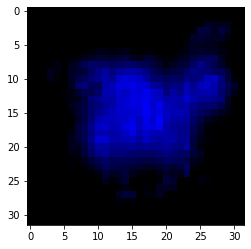

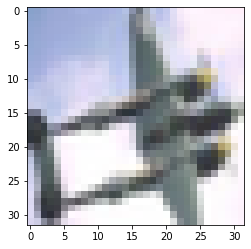

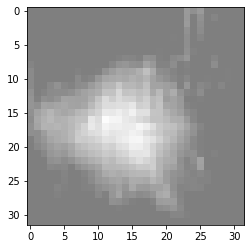

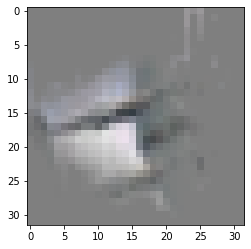

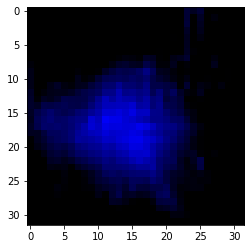

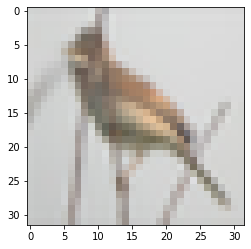

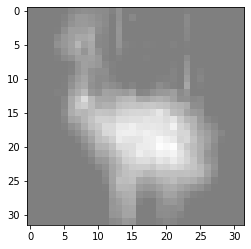

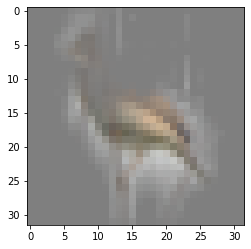

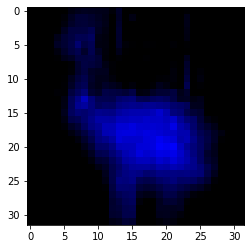

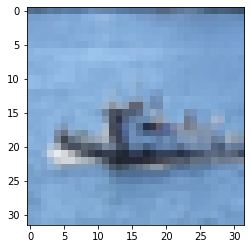

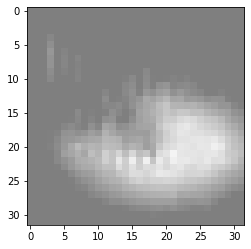

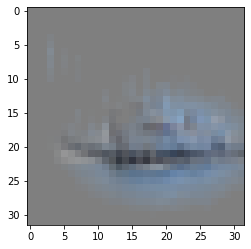

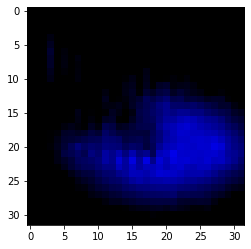

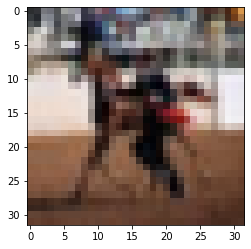

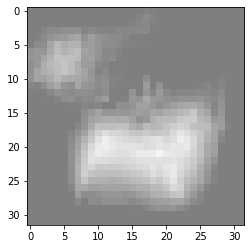

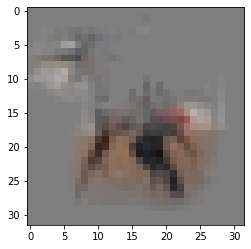

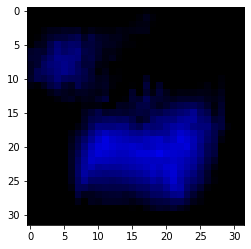

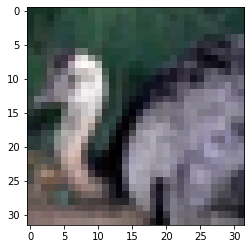

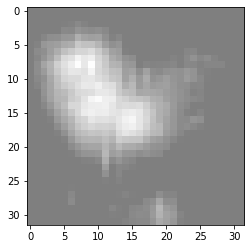

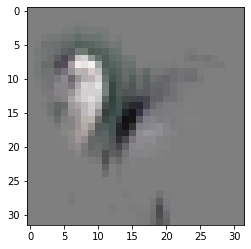

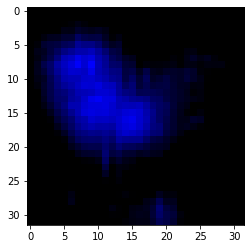

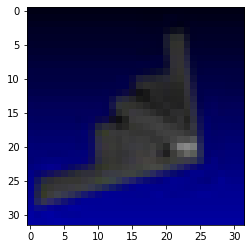

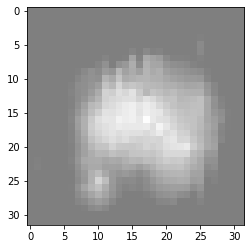

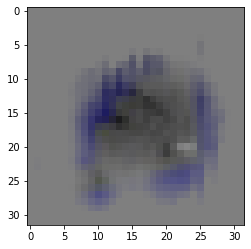

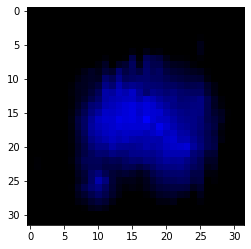

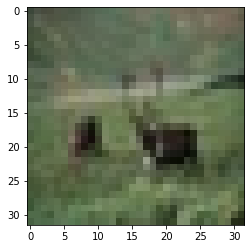

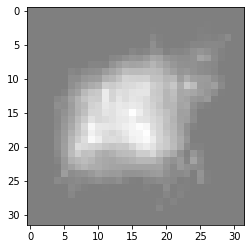

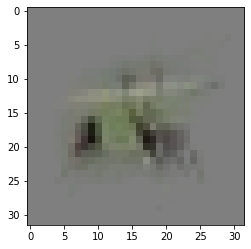

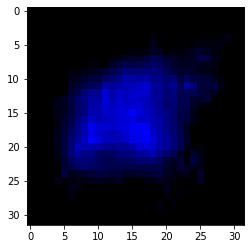

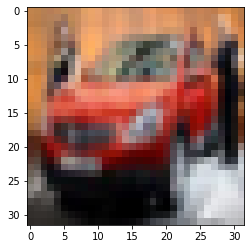

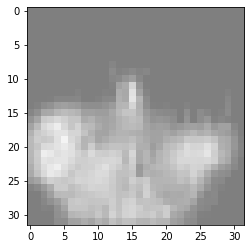

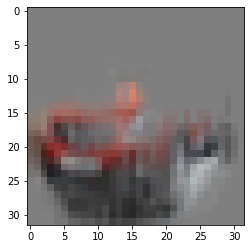

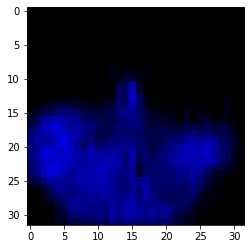

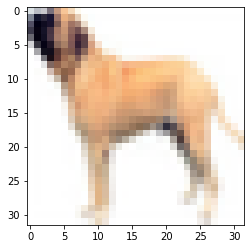

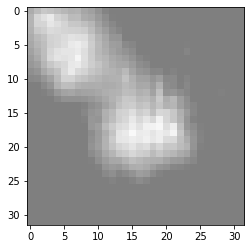

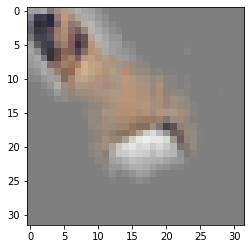

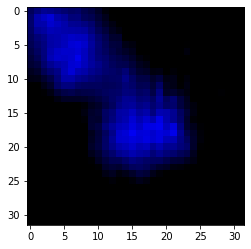

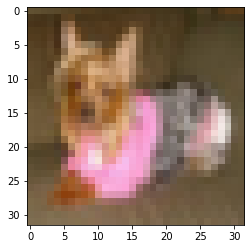

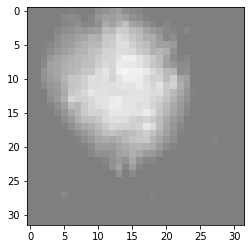

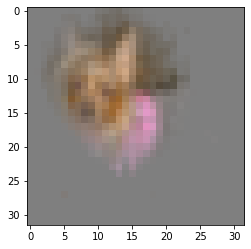

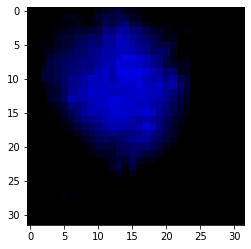

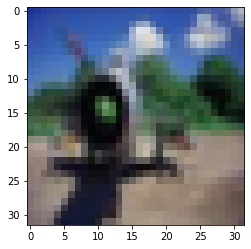

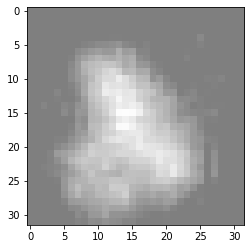

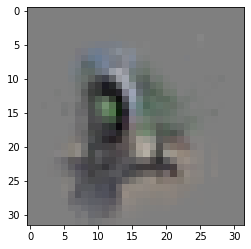

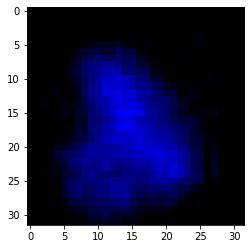

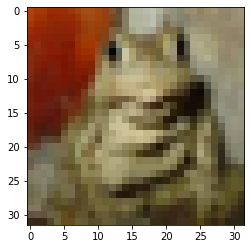

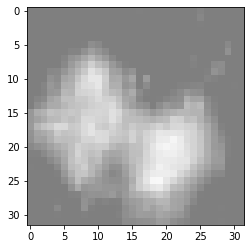

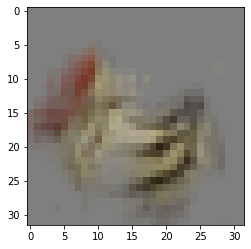

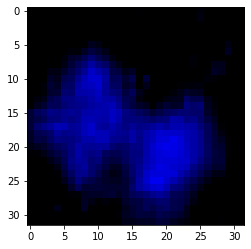

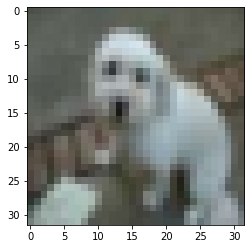

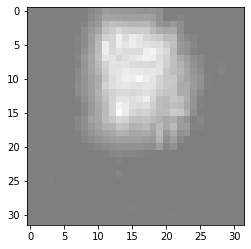

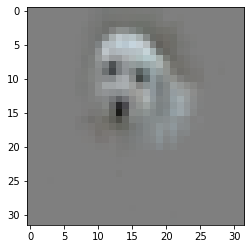

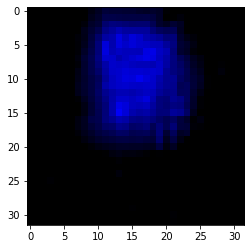

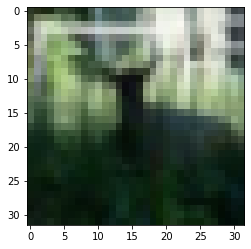

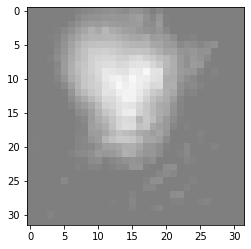

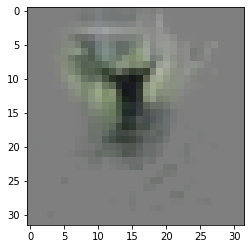

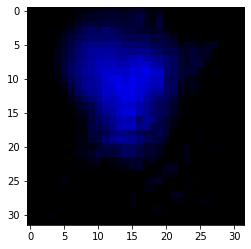

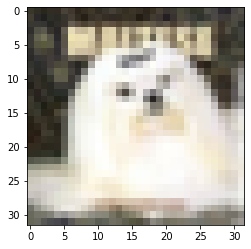

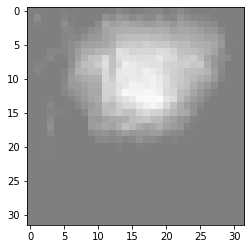

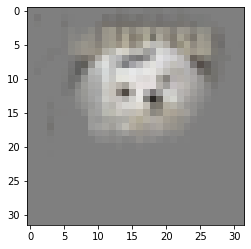

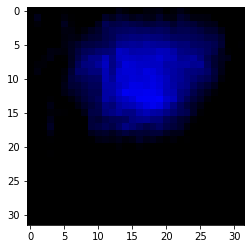

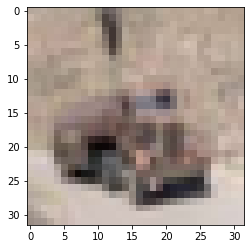

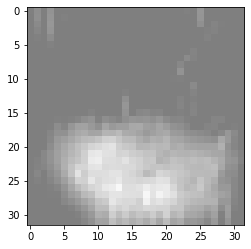

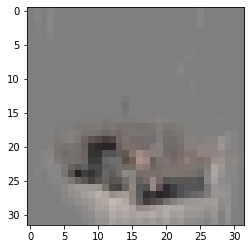

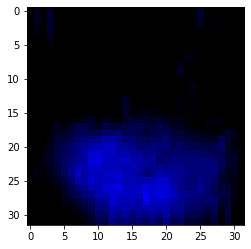

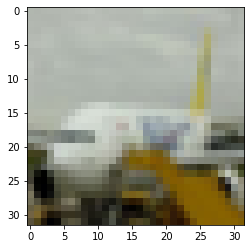

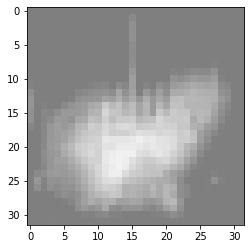

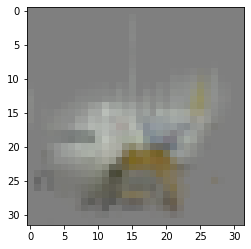

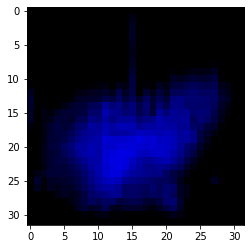

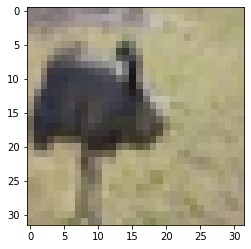

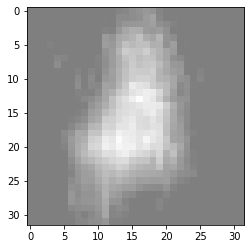

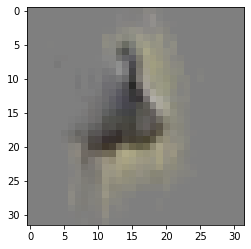

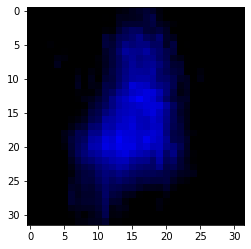

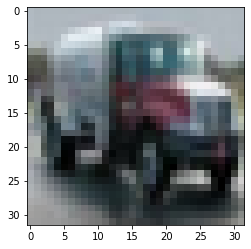

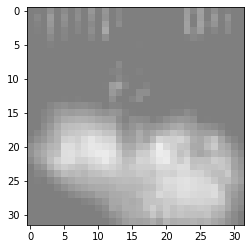

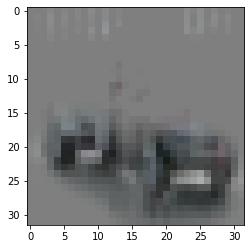

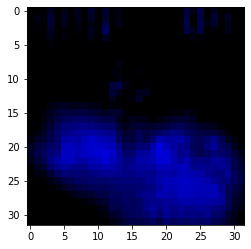

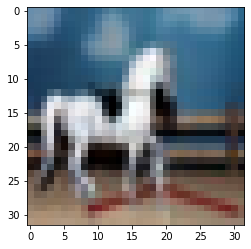

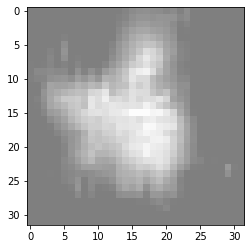

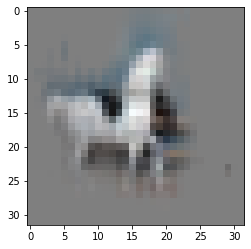

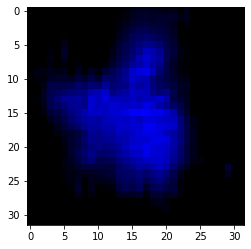

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable

from scipy import misc


import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

def imsave(img,num,name):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    imgname = "output_train/"+str(num) + name+ ".png"
    plt.savefig(imgname)
    plt.show()

def imsavemask(img,num,name):
    img = img / 2 + 0.5    
    # npimg = img.numpy()
    plt.imshow(np.transpose(img, (2, 3, 0,1))[:,:,:,0])
    # plt.imshow(img)

    imgname = "output_train/"+str(num) + name+ ".png"
    plt.savefig(imgname)
    plt.show()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
from model import saliency_model


net = saliency_model()
net = net.cuda()

net = torch.load('saliency_model.pth')

for i, data in enumerate(trainloader, 0):

    inputs, labels = data

    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    if i==100:
        break
    masks,_ = net(inputs,labels)
    #Original Image
    imsave(torchvision.utils.make_grid(inputs.cpu().data),i,"orignal")
    #Mask
    imsave(torchvision.utils.make_grid(masks.cpu().data),i,"mask")
    #Image Segmented
    imsave(torchvision.utils.make_grid((inputs*masks).cpu().data),i,"image_segmented")
    a = 2*np.concatenate((0.*masks.cpu().detach().numpy(), 0.*masks.cpu().detach().numpy(), masks.cpu().detach().numpy()), 0)-1
    imsavemask((a),i,"image_segmented_new")

    

In [ ]:
def imsave(img,num,name):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    imgname = "output/"+str(num) + name+ ".png"
    plt.savefig(imgname)
    plt.show()

for i, data in enumerate(trainloader, 0):

    inputs, labels = data

    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    if i==100:
        break
    masks,_ = net(inputs,labels)
    #Original Image
    imsave(torchvision.utils.make_grid(inputs.cpu().data),i,"orignal")
    #Mask
    imsave(torchvision.utils.make_grid(masks.cpu().data),i,"mask")
    #Image Segmented
    imsave(torchvision.utils.make_grid((inputs*masks).cpu().data),i,"image_segmented")
    

# Prediction time

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

import time
tic = time.time()
for i, data in enumerate(trainloader, 0):

    inputs, labels = data

    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    if i==1000:
        break
    masks,_ = net(inputs,labels)
toc = time.time()
print("time for predicting mask 1000 images is" ,toc - tic , "seconds")

Files already downloaded and verified
time for predicting mask 1000 images is 20.13783288002014 seconds


In [ ]:
print("Our model predicts at fps of" ,1000/(toc - tic))

Our model predicts at fps of 49.657776283969234
